# Setup

In [3]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.4.0

# install spark-nlp
%pip install spark-nlp==5.1.3

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import json
import sparknlp
import numpy as np
import pandas as pd
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import *
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.sql.types import StringType
from pyspark.sql import SparkSession
from sparknlp.pretrained import PretrainedPipeline

In [5]:
# Import pyspark and build Spark session
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[*]")\
    .config("spark.driver.memory","16G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3")\
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")\
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )\
    .getOrCreate()

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c367cce4-dc18-44f5-991e-b8c9fdd4f3f1;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 369ms :: artifacts dl 29ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

In [6]:
print(f"Spark version: {spark.version}")
print(f"sparknlp version: {sparknlp.version()}")

Spark version: 3.4.0
sparknlp version: 5.1.3


In [7]:
import sagemaker

session = sagemaker.Session()
bucket = session.default_bucket()
print(bucket)

# Create or retrieve a Spark session
spark = SparkSession.builder.appName("ReadS3Parquet").getOrCreate()


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker-us-east-1-224518912016


23/11/20 21:50:14 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Data

In [8]:
# S3 directory path
s3_directory_comms = f"s3a://sagemaker-us-east-1-433974840707/project/nlp_cleaned_comments/"

# Read all the Parquet files in the directory into a DataFrame
comments_cleaned = spark.read.parquet(s3_directory_comms)

23/11/20 21:50:14 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [9]:
# S3 directory path
s3_directory_subs = f"s3a://sagemaker-us-east-1-433974840707/project/nlp_cleaned_submissions/"

# Read all the Parquet files in the directory into a DataFrame
submissions_cleaned= spark.read.parquet(s3_directory_subs)

In [10]:
comments_cleaned.printSchema()

root
 |-- author: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: string (nullable = true)
 |-- controversiality: integer (nullable = true)
 |-- created_utc: date (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- retrieved_on: date (nullable = true)
 |-- score: integer (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- cleaned_body: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [11]:
submissions_cleaned.printSchema()

root
 |-- author: string (nullable = true)
 |-- title: string (nullable = true)
 |-- selftext: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- score: integer (nullable = true)
 |-- num_comments: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- created_utc: date (nullable = true)
 |-- url: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- is_video: boolean (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- is_reddit_media_domain: boolean (nullable = true)
 |-- spoiler: boolean (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- thumbnail: string (nullable = true)
 |-- media: string (nullable = true)
 |-- secure_media: string (nullable = true)
 |-- gilded: integer (nullable = true)
 |-- archived: boolean (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- cleaned_body: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- cl

In [12]:
# Group by 'subreddit' and count occurrences
subreddit_counts = submissions_cleaned.groupBy("subreddit").count()

# Order by count in descending order to see the most frequent subreddits first
ordered_subreddit_counts = subreddit_counts.orderBy(F.col("count").desc())

# Show the result
ordered_subreddit_counts.show()

+------------+------+
|   subreddit| count|
+------------+------+
|Conservative|343938|
|changemyview| 64632|
| Libertarian| 51153|
|   Economics| 40604|
|   socialism| 40094|
|     finance| 28904|
|    centrist| 13594|
|     Liberal| 11086|
|Ask_Politics|  5903|
+------------+------+



## Read in Sentiment Data

In [18]:
# Read all the Parquet files in the directory into a DataFrame
comments_sentiment = spark.read.parquet(f"s3a://sagemaker-us-east-1-395393721134/project/nlp/comments/")
submissions_sentiment = spark.read.parquet(f"s3a://sagemaker-us-east-1-395393721134/project/nlp/submissions/")


In [19]:
comments_sentiment.printSchema()

root
 |-- author: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- created_utc: date (nullable = true)
 |-- score: integer (nullable = true)
 |-- controversiality: integer (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- gilded: integer (nullable = true)
 |-- concat_comments: string (nullable = true)



In [20]:
comments_sentiment.groupBy('subreddit').count().show()

+---------+-------+
|subreddit|  count|
+---------+-------+
|socialism| 370695|
|  Liberal|  95706|
|Economics|1425088|
+---------+-------+



## Create Dummy Variables for Inflation and Recession

In [15]:
# Filter rows where either 'cleaned_body' or 'cleaned_title' contains 'recession' and 'subreddit' is 'Economis'
filtered_df = submissions_cleaned.filter(
    (F.array_contains(F.col("cleaned_body"), "recession") | F.array_contains(F.col("cleaned_title"), "recession")) &
    (F.col("subreddit") == "Economics")
)

# Extract month and year 
monthly_yearly_counts = (filtered_df
                         .withColumn("month", F.month("created_utc"))
                         .withColumn("year", F.year("created_utc"))
                         .groupBy("year", "month")
                         .count())

# sort the results
monthly_yearly_counts = monthly_yearly_counts.orderBy("year", "month")

# Show the result
monthly_yearly_counts.show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2021|    1|    7|
|2021|    2|    7|
|2021|    3|    3|
|2021|    4|    7|
|2021|    5|    8|
|2021|    6|    5|
|2021|    7|    8|
|2021|    8|    3|
|2021|    9|    3|
|2021|   10|    4|
|2021|   11|    4|
|2021|   12|    6|
|2022|    1|    4|
|2022|    2|    4|
|2022|    3|   25|
|2022|    4|   30|
|2022|    5|   39|
|2022|    6|   75|
|2022|    7|   91|
|2022|    8|   35|
+----+-----+-----+
only showing top 20 rows



In [16]:
# select the 'count' column and collect the values into a list
counts_list = [row['count'] for row in monthly_yearly_counts.select("count").collect()]

# get all counts
print(counts_list)

[7, 7, 3, 7, 8, 5, 8, 3, 3, 4, 4, 6, 4, 4, 25, 30, 39, 75, 91, 35, 57, 70, 46, 44, 53, 21, 26]


In [33]:
# Filter rows where either 'cleaned_body' or 'cleaned_title' contains 'recession'
filtered_df = submissions_cleaned.filter(
    F.array_contains(F.col("cleaned_body"), "inflation") |
    F.array_contains(F.col("cleaned_title"), "inflation")
)

# extract month and year 
monthly_yearly_counts = (filtered_df
                         .withColumn("month", F.month("created_utc"))
                         .withColumn("year", F.year("created_utc"))
                         .groupBy("year", "month")
                         .count())

# sort the results
monthly_yearly_counts = monthly_yearly_counts.orderBy("year", "month")

# show the result
monthly_yearly_counts.show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2021|    1|   63|
|2021|    2|   97|
|2021|    3|  118|
|2021|    4|   88|
|2021|    5|  213|
|2021|    6|  195|
|2021|    7|  187|
|2021|    8|  129|
|2021|    9|   90|
|2021|   10|  193|
|2021|   11|  345|
|2021|   12|  276|
|2022|    1|  313|
|2022|    2|  302|
|2022|    3|  304|
|2022|    4|  286|
|2022|    5|  357|
|2022|    6|  519|
|2022|    7|  366|
|2022|    8|  428|
+----+-----+-----+
only showing top 20 rows



In [24]:
# Filter rows where either 'cleaned_body' or 'cleaned_title' contains 'recession'
filtered_df = submissions_cleaned.filter(
    F.array_contains(F.col("cleaned_body"), "inflation") |
    F.array_contains(F.col("cleaned_title"), "inflation")
)

# extract month and year 
inflation_counts = (filtered_df
                         .withColumn("month", F.month("created_utc"))
                         .withColumn("year", F.year("created_utc"))
                         .groupBy("year", "month")
                         .count())

# sort the results
inflation_counts = inflation_counts.orderBy("year", "month")

# show the result
inflation_counts.show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2021|    1|   63|
|2021|    2|   97|
|2021|    3|  118|
|2021|    4|   88|
|2021|    5|  213|
|2021|    6|  195|
|2021|    7|  187|
|2021|    8|  129|
|2021|    9|   90|
|2021|   10|  193|
|2021|   11|  345|
|2021|   12|  276|
|2022|    1|  313|
|2022|    2|  302|
|2022|    3|  304|
|2022|    4|  286|
|2022|    5|  357|
|2022|    6|  519|
|2022|    7|  366|
|2022|    8|  428|
+----+-----+-----+
only showing top 20 rows



In [25]:
# select the 'count' column and collect the values into a list
inflation_count_list = [row['count'] for row in inflation_counts.select("count").collect()]

# get all sentiment values
print(inflation_count_list)

[63, 97, 118, 88, 213, 195, 187, 129, 90, 193, 345, 276, 313, 302, 304, 286, 357, 519, 366, 428, 357, 336, 265, 164, 121, 137, 138]


In [22]:
# Filter rows for 'Economics' subreddit
filtered_df = comments_sentiment.filter(F.col("subreddit") == "Economics")

# Extract month and year from 'created_utc' and group by them
average_scores = (filtered_df
                  .withColumn("month", F.month("created_utc"))
                  .withColumn("year", F.year("created_utc"))
                  .groupBy("year", "month")
                  .agg(F.avg("score").alias("average_score")))

# sort the result
average_scores = average_scores.orderBy("year", "month")

# Show the result
average_scores.show()

+----+-----+------------------+
|year|month|     average_score|
+----+-----+------------------+
|2021|    1|6.1806443970623075|
|2021|    2| 5.423235919615761|
|2021|    3| 5.795275140144148|
|2021|    4| 6.047111529334751|
|2021|    5| 6.353800810512096|
|2021|    6| 6.955136427238806|
|2021|    7| 7.203067812641362|
|2021|    8| 6.789323633503736|
|2021|    9|  6.42263845772572|
|2021|   10| 7.368060001829324|
|2021|   11| 7.263392992798322|
|2021|   12| 6.507206548750183|
|2022|    1| 6.616237020199411|
|2022|    2| 7.015992272190619|
|2022|    3| 6.744767331433998|
|2022|    4| 7.135239582316776|
|2022|    5| 7.415242963170424|
|2022|    6| 7.195640638393404|
|2022|    7| 7.612783711615488|
|2022|    8|    6.838779395873|
+----+-----+------------------+
only showing top 20 rows



In [23]:
# select the 'count' column and collect the values into a list
scores_list = [row['average_score'] for row in average_scores.select("average_score").collect()]

# get all sentiment values
print(scores_list)

[6.1806443970623075, 5.423235919615761, 5.795275140144148, 6.047111529334751, 6.353800810512096, 6.955136427238806, 7.203067812641362, 6.789323633503736, 6.42263845772572, 7.368060001829324, 7.263392992798322, 6.507206548750183, 6.616237020199411, 7.015992272190619, 6.744767331433998, 7.135239582316776, 7.415242963170424, 7.195640638393404, 7.612783711615488, 6.838779395873, 6.894947327350761, 7.716510689683563, 7.677433070866142, 8.506808108503813, 9.76934709793531, 9.409402781104271, 8.634026834700418]


## Get Common Words by Month

In [33]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Filter for 'Economics' subreddit and explode words
economics_df = (submissions_cleaned.filter(F.col("subreddit") == "Economics")
                .withColumn("month", F.month("created_utc"))
                .withColumn("year", F.year("created_utc"))
                .select("year", "month", F.explode("cleaned_body").alias("word"))
                .distinct())

# Exclude the words "remove" and "delete", and filter by word length
excluded_words = ["remove", "delete"]
economics_df = economics_df.filter(
    (~F.col("word").isin(excluded_words)) &
    (F.length("word") > 3) &
    (F.length("word") < 12)
)

# Group by year, month, and word and count occurrences
word_counts = economics_df.groupBy("year", "month", "word").count()

# Define a window spec for ranking words within each year and month group
windowSpec = Window.partitionBy("year", "month").orderBy(F.desc("count"))

# Rank the words
top_words = word_counts.withColumn("rank", F.row_number().over(windowSpec)).filter(F.col("rank") <= 5)

# Concatenate top 5 words for each year-month
top_words_concatenated = (top_words
                          .groupBy("year", "month")
                          .agg(F.concat_ws(", ", F.collect_list("word")).alias("words")))

# Show the results
top_words_concatenated.show()


+----+-----+--------------------+
|year|month|               words|
+----+-----+--------------------+
|2021|    1|reminder, reinves...|
|2021|    4|price, summary, a...|
|2021|    5|major, furnishing...|
|2021|    6|consumer, release...|
|2021|    7|soon, come, plan,...|
|2021|    8|relate, discuss, ...|
|2021|    9|please, open, cre...|
|2021|   10|discussion, natur...|
|2021|   11|economics, discus...|
|2021|   12|discussion, topic...|
|2022|    1|economics, topic,...|
|2022|    2|discussion, discu...|
|2022|    3|relate, topic, th...|
|2022|    4|easy, error, happ...|
|2022|    5|good, useful, hel...|
|2022|    6|view, discussion,...|
|2022|    7|market, today, ju...|
|2022|    8|state, strong, kn...|
|2022|    9|september, thursd...|
|2022|   10|invest, whole, ec...|
+----+-----+--------------------+
only showing top 20 rows



In [34]:
top_words_pandas = top_words_concatenated.toPandas()

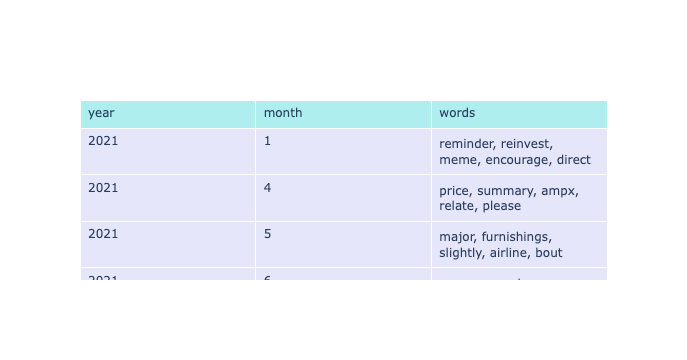

In [35]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(
    header=dict(values=list(top_words_pandas.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[top_words_pandas[k].tolist() for k in top_words_pandas.columns],
               fill_color='lavender',
               align='left'))
])

fig.show()
